<a href="https://colab.research.google.com/github/ryderdavid/metcs767_project_lungstudy/blob/main/notebook_metcs767_project_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Implementing a Convolutional Neural Net on Frontal Lung CXRs from the CheXpert Dataset to Detect Pleural Effusion
Ryder Cobean - ryderd@bu.edu  
Boston University, Metropolitan College  
MET CS 767: Machine Learning  
Professor Eric Braude  
Facilitator Vineet Raghu  

In [ ]:
# misc datasci imports --------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, f1_score


# tensorflow imports ----------------------
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D, MaxPooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image


# misc imports (not standard library)
import cv2 as cv


# standard library imports ----------------
import random  # for sampling
import shutil  # for copying images to smaller subsample set for experimentation
import datetime
import os
import re
import sys


# install unzip 
!apt install unzip

# nice-to-have packages for some reach goals
!pip install tf-keras-vis  # visualize a conv layer
!pip install tensorflow_io  # read in dicoms
!pip install pydicom  # read in dicoms

import tensorflow_io as tfio  # load dicoms
import pydicom  # load dicoms
import tf_keras_vis  # visulaizing
from tf_keras_vis.activation_maximization import ActivationMaximization  # visualizing

# Mount drive 
from google.colab import drive
drive.mount('/content/drive')

Reading package lists... Done
Building dependency tree       
Reading state information... Done
unzip is already the newest version (6.0-21ubuntu1.1).
0 upgraded, 0 newly installed, 0 to remove and 12 not upgraded.
Mounted at /content/drive


Below cell confirms that GPU is enabled

In [ ]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
physical_devices

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### Global Variables and Functions
In here are some global variables, loading the main dataset, 
and relabeling classes from binary to yes/no.

In [ ]:
HERE = '/content/drive/MyDrive/Colab Projects/METCS767_LungStudy'
SAMPLE_DIR = os.path.join(HERE, 'data', 'chexpert_reorganized_frontal_PE_study')
SEED = 999

# load the dataset for all
img_files_df = pd.read_csv(os.path.join(SAMPLE_DIR, 'img_files.csv'))

# rename numeric to yes/no for class labels
bin_to_lbl = lambda x: "yes" if x == 1.0 else "no"
img_files_df.pleural_effusion = img_files_df.pleural_effusion.apply(bin_to_lbl)

In [ ]:
# utility functions
def plot_sample_images(img_df, title):
  images_to_plot = img_df.sample(9)

  yesct = img_df.assign(images=1).query("pleural_effusion == 'yes'").sum()['images']
  noct = img_df.assign(images=1).query("pleural_effusion == 'no'").sum()['images']

  title = f"\n{title}\n({noct} negative, {yesct} positive)"

  figs, axes = plt.subplots(nrows=3, ncols=3, figsize=(10,10))
  figs.suptitle(title, size='large')
  for i, row in images_to_plot.reset_index().iterrows():
    if i == 0:
      axes.flatten()[i].set_title("Image counts")
      axes.flatten()[i].bar(['no', 'yes'], [noct, yesct])
      continue

    img = cv.imread(os.path.join(SAMPLE_DIR, row.project_path))
    axes.flatten()[i].imshow(img)
    axes.flatten()[i].set_xticks([])
    axes.flatten()[i].set_yticks([])
    axes.flatten()[i].set_title(f"Effusion: {row.pleural_effusion}")

  plt.show()
    

"""
load or save history of training data as pandas df, either from past run, or 
from fresh run if data is missing
"""
def load_or_save_history(model=None, history_path=None):
  if os.path.exists(history_path):
    hist = pd.read_csv(history_path)
  else:
    hist = pd.DataFrame(model.history)
    hist.to_csv(history_path, index=False)

  return hist


# model train template
def load_or_train_model(training_set=None, 
                        resize=200, 
                        model=None, 
                        model_name=None,
                        epochs=10,
                        learnrate=0.0001): 

  model_path = os.path.join(HERE, 'models', model_name)
  history_path = os.path.join(HERE, 'models', f"{model_name}_history.csv")

  if model_path is not None:
    if os.path.exists(model_path):
      model = tf.keras.models.load_model(model_path)
      history_df = pd.read_csv(history_path)

      # fix columns if df was originally saved with 'val_auc_d+' format
      history_df.columns = history_df.columns.str.replace("_\\d+", "")
    else:                   
      batch_size = 32

      # resize the images
      img_height = resize
      img_width = resize

      datagen = ImageDataGenerator(
        validation_split=0.20
      )


      t = datagen.flow_from_dataframe(
          dataframe=training_set,
          directory=os.path.join(HERE, SAMPLE_DIR),
          x_col="project_path",
          y_col="pleural_effusion",
          target_size=(img_height, img_width),
          color_mode="grayscale",
          class_mode="binary",
          batch_size=batch_size,
          shuffle=True,
          seed=SEED,
          save_prefix="",
          save_format="jpg",
          subset='training',
          interpolation="nearest"
      )

      v = datagen.flow_from_dataframe(
          dataframe=training_set,
          directory=os.path.join(HERE, SAMPLE_DIR),
          x_col="project_path",
          y_col="pleural_effusion",
          target_size=(img_height, img_width),
          color_mode='grayscale',
          class_mode='binary',
          batch_size=batch_size,
          shuffle=True,
          seed=SEED,
          save_prefix="",
          save_format="jpg",
          subset='validation',
          interpolation="nearest"
      )

      model.summary()

      opt = tf.keras.optimizers.Adam(learning_rate=learnrate)

      model.compile(
          optimizer=opt,
          loss='binary_crossentropy',
          metrics=[
              'accuracy',
              tf.keras.metrics.AUC()
          ]
      )

      start = datetime.datetime.now()
      history = model.fit(x=t, validation_data=v, epochs=epochs, verbose=1)
      history_df = pd.DataFrame(history.history)

      # fix columns if df was originally saved with 'val_auc_d+' format
      history_df.columns = history_df.columns.str.replace("_\\d+", "")

      history_df.to_csv(history_path, index=False)
      print(f"Saved history to {history_path}.")
      model.save(model_path)
      end = datetime.datetime.now()

      diff = (end - start)
      print(f"Total time to train: {str(diff)}") 

    return model, history_df

## Datasets

### Main Dataset

The dataset I uploaded here is a filtered version of the [full CheXpert (small) dataset](https://stanfordmlgroup.github.io/competitions/chexpert/), with a custom script built to sample from the larger set just those records I wanted. For this project, I focused only on the 102,198 frontal (not lateral) images which were labeled as either having or not having pleural effusion with certainty (0.0 = negative; 1.0 = positive).

I separated out a test set from this total population, which will be randomly selected sample of images of all characteristics (of both the more preferred posterior-anterior angle, and the less preferred anterior-posterior; and not being balanced in its representation of positive and negative labels). 

I will use this test set to compare the effectiveness of models which are:
  1. Trained only on PA images, with class balance roughly 'naturally' occuring within the sample (n = 13,000)
  2. Trained only on AP images, with class imbalance as it 'naturally' occurs (n = 13,000)
  3. Trained only on AP images, with class balance imposed (with resampling) (n = 13,000)
  4. Trained with both AP and PA images, with class imbalance as it 'naturally' occurs (n = 13,000)
  5. Trained with both AP and PA images, with class balance imposed (with resampling) (n = 13,000)
  6. The full train split (all images) (n = ~81,758 -- 80% of total dataset)
  
From here, I plan on creating a number of resamples, the main being:

  - A dataset with posterior-anterior (PA)-only images; these are preferred scans by doctors if the patient is able to stand, as they produce clearer imagery; by luck of sample distribution, this subset is fairly balanced in class distribution.
  - another dataset with mixed posterior-anterior images, to add some more difficult images to process, and with artificial resampling to balance the class labels.
  - another dataset with intense class imbalance, with mixed PA-AP imagery.

The initial selection had to happen outside of Colab as the full dataset is more than 250,000 images and Google Drive times out when trying to parse that many files or subdirectories in a folder. In my offline file, I filtered the files to upload and reorganized them programmatically in a new directory, chunked (for Google limitations reasons) into folders of approximately 500 images each. A master record is kept of their contents in a dataframe saved to CSV.

### Train-Test Split
Per feedback with my facilitator, the final design will use a single test partition against which each different training sample will be assessed. This allows us to have a common baseline of effectiveness across different models.

In [ ]:
# create master train-test split -----------------------------------------------
train, test = train_test_split(img_files_df, test_size=0.2, random_state=SEED)
print(f"Sizes of Train and Test splits: {train.shape[0]}, {test.shape[0]}.")

# create a test dataset from the test split ------------------------------------
# (keras train sets are taken care of in the model builder function and train 
# samples created below)
batch_size = 32

# resize the images
img_height = 64
img_width = 64

datagen = ImageDataGenerator()

test_ds = datagen.flow_from_dataframe(
    dataframe=test,
    directory=os.path.join(HERE, SAMPLE_DIR),
    x_col="project_path",
    y_col="pleural_effusion",
    # weight_col=None,
    target_size=(img_height, img_width),
    color_mode="grayscale",
    class_mode="binary",
    batch_size=batch_size,
    shuffle=False,
    seed=SEED,
    save_prefix="",
    save_format="jpg",
    interpolation="nearest"
)

Sizes of Train and Test splits: 81758, 20440.
Found 20440 validated image filenames belonging to 2 classes.


## I. Initial model architecture
In order for us to get results we can compare for all training sets, we will use the same model architecture for each training run. This model employs:
  1. A 32-filter relu-activated convolutional layer, with each filter being 9 x 9 pixels, and padding around each input image such that the output feature map is the same size;
  2. A max-pool layer which reduces the output feature maps to 50% size;
  3. A second 64-filter relu-activated convolutional layer, with each filter being 9 x 9, and again padded such that the output is the same size as the input;
  4. A second max-poll layer reducing the input again by half;
  5. A flattening layer which takes the 16 x 16 x 64 feature maps and flattens them to all 16,384 neurons; 
  6. A dense layer which feeds each neuron into a single output node, activated by the sigmoid function, such that the output is a probability for each image between the negative and the positive classes.

In [ ]:
resize = 64  # resize all images to 64 x 64

default_model = Sequential([
    Conv2D(filters=32, kernel_size=(9, 9), activation='relu', padding = 'same', 
           input_shape=(resize, resize, 1)),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=64, kernel_size=(9, 9), activation='relu', padding = 'same'),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Flatten(),
    Dense(units=1, activation='sigmoid')
])

default_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 32)        2624      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        165952    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 16384)             0         
_________________________________________________________________
dense (Dense)                (None, 1)                 16385     
Total params: 184,961
Trainable params: 184,961
Non-trainable params: 0
__________________________________________________

### Model Architecture 1: Training

#### Sample 1: PA Only
This current slice is from a sample set of 13,000 (nearly all) frontal images taken by PA angle only. I've rounded to 13,000 to make this be the same size as for the other datasets I will compare performance to.
  
Effusions appear as opaque white areas toward the bottom of one or both lungs.

TypeError: ignored

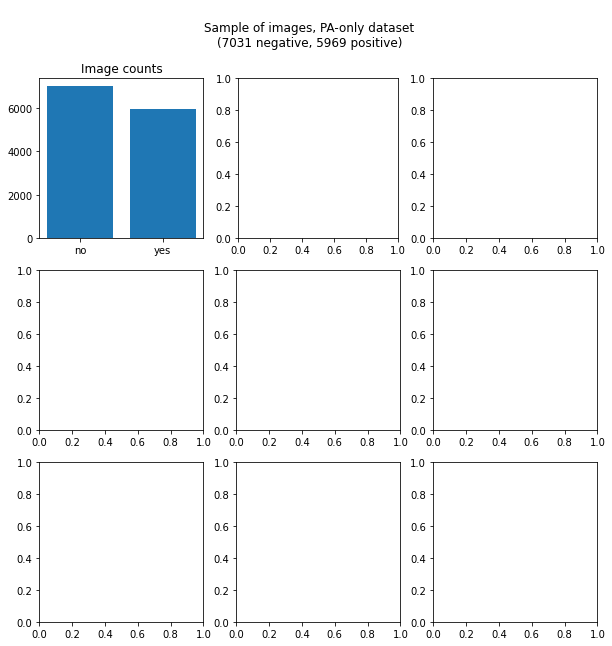

In [ ]:
train_pa = train.query("ap_pa == 'PA'").sample(13000, random_state=SEED)
plot_sample_images(train_pa, "Sample of images, PA-only dataset")

In [ ]:
model_pa13k, history_pa13k = load_or_train_model(training_set=train_pa, 
                                                 resize=resize, 
                                                 model=default_model,
                                                 model_name='pa13k',
                                                 epochs=100)

history_pa13k.drop(['val_binary_crossentropy', 'binary_crossentropy'], 1)

#### Sample 2: AP only
The second model will attempt to classify pleural effusion using Anterior-Posterior images, which are [considered "less useful" by medical professionals given their angle of imaging resulting in a hazier image](https://https://www.med-ed.virginia.edu/courses/rad/cxr/technique3chest.html). We will see if using these images is more difficult for the model to train on.

As visible below, this sample is very class imbalanced. I will also run one with class balancing employed.

In [ ]:
train_ap = train.query("ap_pa == 'AP'").sample(13000, random_state=SEED)
plot_sample_images(train_ap, "Sample of images, AP-only dataset")

In [ ]:
# if i've already trained the model, load it from above path, 
# otherwise train it and save to above path
model_ap13k, history_ap13k = load_or_train_model(training_set=train_ap,
                                                 resize=resize,
                                                 model=default_model,
                                                 model_name='ap13k')

history_ap13k.drop(['val_binary_crossentropy', 'binary_crossentropy'], 1)

,loss,accuracy,auc,val_loss,val_accuracy,val_auc
0,0.463158,0.813269,0.687350,0.430788,0.828077,0.721475
1,0.426227,0.825192,0.738612,0.431826,0.831538,0.742423
2,0.407350,0.832885,0.770349,0.429493,0.828846,0.715816
3,0.397862,0.830673,0.786814,0.423348,0.828077,0.741506
4,0.385852,0.837788,0.801776,0.445563,0.821538,0.704530
5,0.373531,0.844904,0.817562,0.438565,0.823846,0.732354
6,0.354266,0.850481,0.840849,0.464618,0.819615,0.755828
7,0.337528,0.859423,0.856644,0.478902,0.823846,0.707214
8,0.334246,0.857692,0.858937,0.526324,0.812692,0.683562
9,0.288202,0.879615,0.900226,0.552500,0.820000,0.696104


#### Sample 3: AP-only, with rebalancing
The following is a resampled version of 13,000 AP images, with a perfect balance of positive and negative lung images.



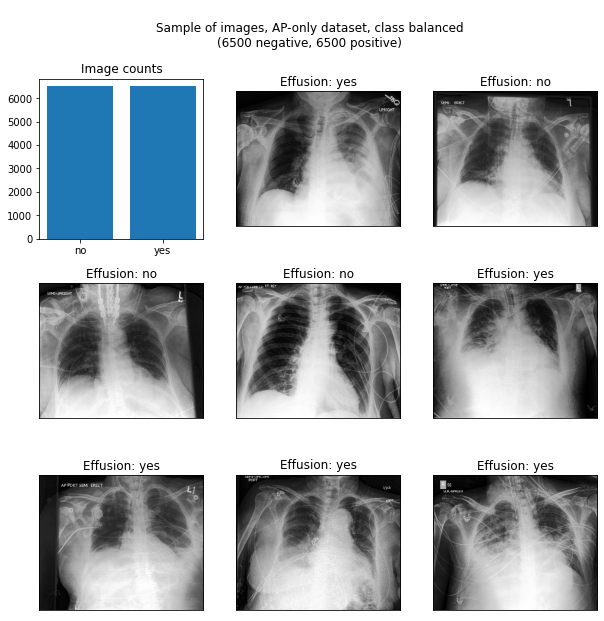

In [ ]:
ap_yes = train.query("pleural_effusion == 'yes' and ap_pa == 'AP'").sample(6500, random_state=SEED).copy()
ap_no = train.query("pleural_effusion == 'no' and ap_pa == 'AP'").sample(6500, random_state=SEED).copy()

train_ap_bal = pd.concat([ap_no, ap_yes]).sort_index().copy()
plot_sample_images(train_ap_bal, "Sample of images, AP-only dataset, class balanced")

In [ ]:
# train model on 13,000 AP images, balanced
model_ap13k_bal, history_ap13k_bal = load_or_train_model(train_ap_bal, 
                                                         resize=resize, 
                                                         model=default_model, 
                                                         model_name='ap13k_bal')

history_ap13k_bal.drop(['val_binary_crossentropy', 'binary_crossentropy'], 1)

,loss,accuracy,auc,val_loss,val_accuracy,val_auc
0,0.591726,0.706058,0.771637,0.546054,0.738077,0.799773
1,0.540677,0.736154,0.809129,0.546931,0.725385,0.808642
2,0.520951,0.752596,0.824504,0.547568,0.738846,0.810712
3,0.488837,0.767500,0.845240,0.531328,0.752692,0.821730
4,0.479716,0.778077,0.853844,0.601237,0.729615,0.822819
5,0.451540,0.791058,0.871233,0.589167,0.746538,0.812348
6,0.426473,0.805000,0.885460,0.604164,0.741538,0.799751
7,0.396717,0.823462,0.901550,0.664611,0.709615,0.774598
8,0.384991,0.829615,0.907872,0.734624,0.724615,0.788720
9,0.360033,0.841058,0.919393,0.692506,0.718077,0.781940


#### Sample 4: 13,000 images, of both PA and AP angles (not rebalanced)
To better approximate the fuller breadth of the data, another model is built using both AP and PA images.

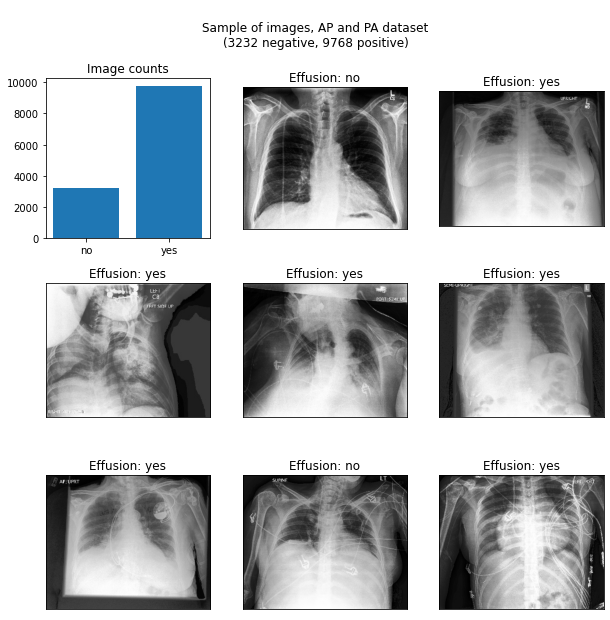

In [ ]:
train_appa = train.sample(13000, random_state=SEED)
plot_sample_images(train_appa, "Sample of images, AP and PA dataset")

In [ ]:
# train model on 13,000 AP images, balanced
model_appa13k, history_appa13k = load_or_train_model(train_appa, 
                                                     resize=resize, 
                                                     model=default_model, 
                                                     model_name='appa13k')

history_appa13k.drop(['val_binary_crossentropy', 'binary_crossentropy'], 1)

,loss,accuracy,auc,val_loss,val_accuracy,val_auc
0,0.500516,0.791250,0.779277,0.468131,0.791154,0.779929
1,0.412917,0.820192,0.839563,0.443078,0.818846,0.837240
2,0.397932,0.829712,0.852262,0.449899,0.811923,0.813679
3,0.369663,0.838077,0.872947,0.462871,0.805769,0.811974
4,0.358121,0.847692,0.880183,0.495525,0.790769,0.820995
5,0.347132,0.853462,0.889389,0.475857,0.814231,0.821837
6,0.318270,0.863077,0.907009,0.477136,0.808462,0.804319
7,0.322023,0.864615,0.905670,0.535966,0.800000,0.789936
8,0.299637,0.875673,0.918561,0.545091,0.795769,0.781804
9,0.299951,0.873462,0.920983,0.553371,0.803462,0.796649


#### Sample 5: 13,000 images, of both PA and AP angles (rebalanced)
To better approximate the fuller breadth of the data, another model is built using both AP and PA images. This sample is rebalanced.

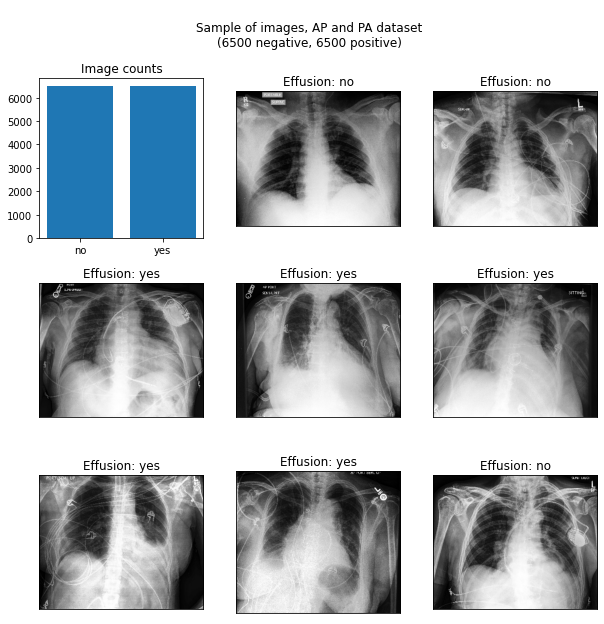

In [ ]:
appa_yes = train.query("pleural_effusion == 'yes'").sample(6500, random_state=SEED)
appa_no = train.query("pleural_effusion == 'no'").sample(6500, random_state=SEED)

train_appa_bal = pd.concat([appa_no, appa_yes]).sort_index()
plot_sample_images(train_appa_bal, "Sample of images, AP and PA dataset")

In [ ]:
# train model on 13,000 AP images, balanced
model_appa13k_bal, history_appa13k_bal = load_or_train_model(train_appa_bal, 
                                                             resize=resize, 
                                                             model=default_model, 
                                                             model_name='appa13k_bal')

history_appa13k_bal.drop(['val_binary_crossentropy', 'binary_crossentropy'], 1)

,loss,accuracy,auc,val_loss,val_accuracy,val_auc
0,0.538267,0.755288,0.824416,0.544681,0.773846,0.852721
1,0.485045,0.774231,0.849986,0.535837,0.769615,0.841600
2,0.455643,0.788846,0.868616,0.564304,0.770385,0.836720
3,0.441372,0.803077,0.877716,0.560240,0.772692,0.843112
4,0.436562,0.803846,0.881183,0.572748,0.770769,0.838568
5,0.415552,0.815096,0.892828,0.610812,0.760000,0.831595
6,0.391541,0.826442,0.905023,0.642704,0.757692,0.824291
7,0.372549,0.836731,0.914472,0.734014,0.732308,0.799325
8,0.351373,0.845288,0.924079,0.708847,0.753846,0.815120
9,0.333475,0.857596,0.931489,0.779839,0.751538,0.818307


#### Sample 6: ALL images
To test limitations of a large dataset and to get performance of all items in training set, I also trained a model on all existing images in my training set, 
with 81,578 images in the set after the training partition that was prior witheld. Of these, 20% are used for sameation, so roughly 65,400 images.

Given the how the dataset size for neural nets is so tied to their performance, I suspect that this model, trained on this dataset, will be the most performant. 

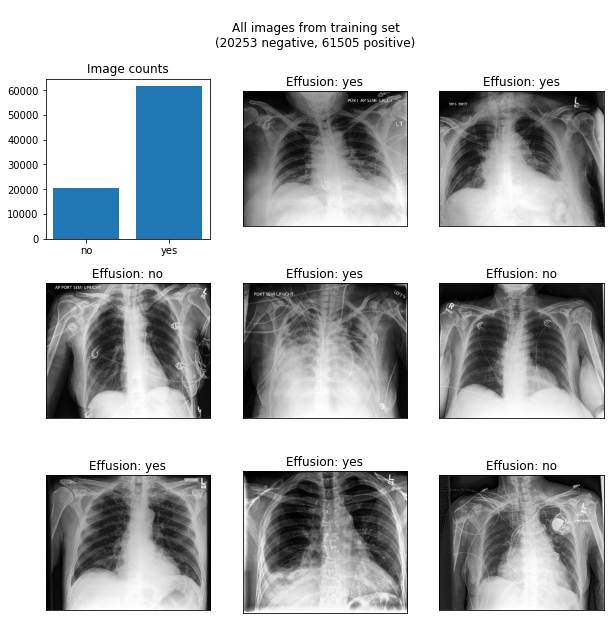

In [ ]:
plot_sample_images(train, "All images from training set")

In [ ]:
model_all, history_all = load_or_train_model(training_set=train, 
                                             resize=resize, 
                                             model=default_model, 
                                             model_name='all_82k')

history_all.drop(['val_binary_crossentropy', 'binary_crossentropy'], 1)

,loss,accuracy,auc,val_loss,val_accuracy,val_auc
0,0.437142,0.817986,0.827467,0.411053,0.819277,0.839139
1,0.405310,0.824667,0.845041,0.388769,0.832059,0.858894
2,0.401950,0.825508,0.847609,0.426343,0.825638,0.850846
3,0.398731,0.828872,0.849901,0.393982,0.831448,0.857460
4,0.398060,0.827618,0.850170,0.404278,0.830897,0.852371
5,0.395047,0.831440,0.852331,0.412286,0.828634,0.850570
6,0.391935,0.831517,0.854944,0.412540,0.829368,0.852603
7,0.404057,0.827572,0.844942,0.423461,0.826800,0.847274
8,0.392772,0.832388,0.855538,0.425768,0.830836,0.850496
9,0.386768,0.833917,0.860256,0.424801,0.828695,0.852166


### Architecture 1: validation metrics
Below are per-epoch AUC scores on validation partitions as assessed during training. Best performers during validation are the all images set, and the balanced mixed AP-PA set.

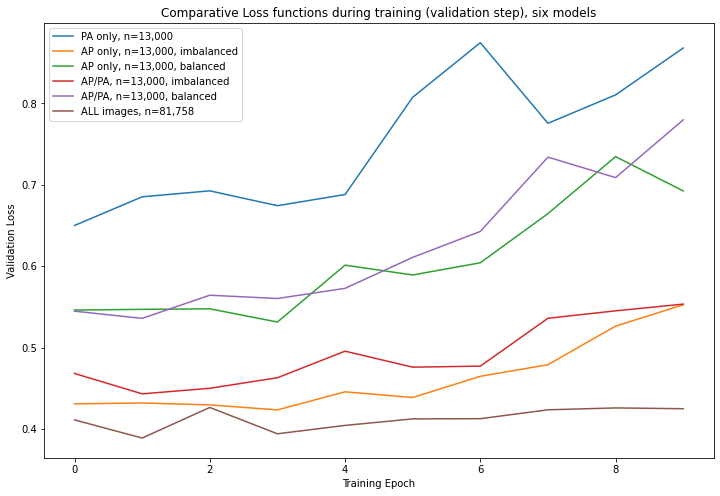

In [ ]:
plt.rcParams["figure.figsize"] = (12, 8)

plt.plot(range(10), history_pa13k.val_loss)
plt.plot(range(10), history_ap13k.val_loss)
plt.plot(range(10), history_ap13k_bal.val_loss)
plt.plot(range(10), history_appa13k.val_loss)
plt.plot(range(10), history_appa13k_bal.val_loss)
plt.plot(range(10), history_all.val_loss)

plt.legend([
  "PA only, n=13,000",
  "AP only, n=13,000, imbalanced",
  "AP only, n=13,000, balanced",
  "AP/PA, n=13,000, imbalanced",
  "AP/PA, n=13,000, balanced",
  f"ALL images, n={train.shape[0]:,.0f}"
])
plt.title("Comparative Loss functions during training (validation step), six models")
plt.xlabel('Training Epoch')
plt.ylabel('Validation Loss')
plt.show()

While we can see a clear split in performance of each during training, **a problem is that for each model, there is clearly some problem in training in that the loss function does not decrease.** This could represent a problem with the design of the model itself, a bad learning rate in the optimizer algorithm, both, or neither (something else). To improve, I will try a different model design, and a lower learning rate. The following characteristics were reached via some outside research and trial and error. 


**Research sources below:**

1.   [How to Reduce Overfitting With Dropout Regularization in Keras](https://machinelearningmastery.com/how-to-reduce-overfitting-with-dropout-regularization-in-keras/)
2.   [CS231n Convolutional Neural Networks for Visual Recognition, Stanford University](https://cs231n.github.io/convolutional-networks/#architectures)
3.   [A Simple Convolutional Neural Network Summary for Binary Image Classification With Keras.](https://medium.com/swlh/a-simple-convolutional-neural-network-summary-for-binary-image-classification-with-keras-d58caf2f84a4)

  > "You’ll find that a lot of models will repeat this alternating step of adding a convolutional layer and then a pooling layer so you’ll have more hidden layers to train with, and achieve better accuracy. A good idea when adding more layers will be to raise the number of filter parameters used as you add more layers so the model will learn more complex patterns in the images."

**Things I learned from experimentation and research:**

* I was on the right track with having a larger first filter size (9 * 9) to catch broad patterns up front, but one possible different approach could be to use many (in this case twice as many) filters in the second convolutional layer 
of a smaller size to catch smaller details.
* In contrast with many model designs that are considered robust, my architecture was missing a fully connected layer near the end; it went straight from flattening into a single-node sigmoid. My new model introduces a fully connected layer of 128 nodes, in which each flattened neuron connects to 128 additional neurons to allow for one additional layer of tuning via weights and the relu function.
* To protect against overfitting, I introduced a dropout layer, which during each run, adds a 40% probability that by random sampling, before the final dense layer (single node sigmoid prediction output), that a given input is zeroed out.
* Finally, I also could improve, potentially, the possible overfitting (great train metrics, worse and worsening over epochs validation metrics) by reducing my learning rate (by which the Adam optimizer adjusts weights).


### Architecture 1: Predict new values, evaluate test set performance

In [ ]:
preds_path = os.path.join(HERE, 'test_with_predictions.csv')

if os.path.exists(preds_path):
  test_with_preds = pd.read_csv(preds_path)

else:
  start = datetime.datetime.now()

  test_with_preds = test.assign(**{
    'pred_pa13k': model_pa13k.predict(test_ds, verbose=1), 
    'pred_ap13k' : model_ap13k.predict(test_ds, verbose=1),
    'pred_ap13k_bal': model_ap13k_bal.predict(test_ds, verbose=1),
    'pred_appa13k' : model_appa13k.predict(test_ds, verbose=1),
    'pred_appa13k_bal' : model_appa13k_bal.predict(test_ds, verbose=1),
    'pred_all' : model_all.predict(test_ds, verbose=1)
  })
  test_with_preds.to_csv(preds_path, index=False)

  end = datetime.datetime.now()
  dur = (end - start).total_seconds()
  print(f"Took {dur} seconds to predict.")

test_with_preds = test_with_preds[[
  'index'
  , 'old_index'
  , 'project_path'
  , 'ap_pa'
  , 'pleural_effusion'
  , 'pred_pa13k'
  , 'pred_ap13k_bal'
  , 'pred_ap13k'
  , 'pred_appa13k_bal'
  , 'pred_appa13k'
  , 'pred_all'
]]

# relabel our yes/nos as numeric so sklearn can compute 
# TPR/FPR numerically
test_with_preds['ground_truth'] = (
    test_with_preds
    .pleural_effusion
    .apply(lambda x: 1.0 if x == 'yes' else 0.0)
)

test_with_preds

,index,old_index,project_path,ap_pa,pleural_effusion,pred_pa13k,pred_ap13k_bal,pred_ap13k,pred_appa13k_bal,pred_appa13k,pred_all,ground_truth
0,77437,171880,subfolder_154/img_077437.jpg,AP,yes,0.692672,0.358051,0.196354,0.906547,0.960502,0.848912,1.0
1,66530,151917,subfolder_133/img_066530.jpg,AP,yes,0.082276,0.197907,0.861738,0.018222,0.224161,0.415198,1.0
2,51648,120306,subfolder_103/img_051648.jpg,AP,yes,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0
3,36229,84910,subfolder_072/img_036229.jpg,AP,yes,0.911091,0.010255,0.645236,0.369007,0.415194,0.733574,1.0
4,100563,219717,subfolder_201/img_100563.jpg,AP,yes,0.838527,0.104646,0.678312,0.578639,0.698357,0.680627,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
20435,95592,208330,subfolder_191/img_095592.jpg,AP,yes,0.089629,0.043039,0.708992,0.199900,0.156143,0.100282,1.0
20436,29634,69250,subfolder_059/img_029634.jpg,AP,yes,0.998079,0.955680,0.975617,0.995829,0.997211,0.950339,1.0
20437,97170,211906,subfolder_194/img_097170.jpg,AP,no,0.269758,0.009362,0.403554,0.088319,0.429748,0.352388,0.0
20438,63343,146280,subfolder_126/img_063343.jpg,AP,yes,0.073072,0.753822,0.818202,0.175819,0.880823,0.713018,1.0


#### Architecture 1 Performance: Area Under ROC Curve
When working with class label probabilities, a certain amount of uncertainty is bred into the analysis; making a decision about what kind of 'cutoff' is appropriate for deciding you're sure enough about an uncertain prediction (anything other than 1.0 and 0.0) has tradeoffs.  

The [Area Under the ROC Curve](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc#:~:text=An%20ROC%20curve%20(receiver%20operating,False%20Positive%20Rate) is a helpful metric. 

Our tool, scikit-learn, took more than 5000 floating point 'thresholds' between 0.0 and 1.0 to 'cut' each prediction, between negative and positive. This means that instead of just requiring 50.01% as a simple threshold, we run across 5000 different possible cuts, ranging from extremely permissive (0.01 or less, letting just about any guess in), to extremely conservative (don't count it as positive unles you're 99.99999% sure). At each cutting point, we'll have different proportions of **true positive** capture, and **false positive** capture.  
  
If your cutoff is very low, you will capture almost all your true positives (the actually ground-truth true positives), but at the tradeoff that you likely brought in a great many false positives; similarly, at 99.999% cutoff, you may have protected yourself from any false positives, but at the cost of missing most of your actual positive cases. If your goal is to catch water on the lungs, you want to catch as many as possible while minimizing false alarms.

So, the ROC curve plots this tradeoff: 

  - on the X-axis, the False Positive Rate is plotted for any given threshold between 0 and 1.
  - on the Y-axis, the True Positive Rate is plotted for any given threshold between 0 and 1. 
  - A good model extends up and to the left further than others; this means that for any given threshold it captures more true positives, while minimizing bringing along as many false positives as you lower your threshold for what counts as a positive prediction.
  - A relatively bad model is fairly close to the middle line, meaning that it does not capture a great many more true positives as the threshold is lowered, bringing in more false positives.
  - The line right down the middle represents a perfect coin flip; if a model hugs this it is not much better than flipping a coin.
  - If a model dips below the diagonal line, it is actually worse than a coin flip; something went very wrong either with data selection, processing, or elsewhere in the process, and you're actually better off closing the project and finding a quarter to decide.

The metric this project is investigating is the Area Under the Curve (AUC). Using calculus, one can calculate the area between the dotted line and the curve of the tradeoffs; that value, between -1.0 (perfectly wrong for every guess) and +1.0 (perfectly correct) shows the relative strength your model has with regard to this tradeoff.

This project's AUC visualization below:

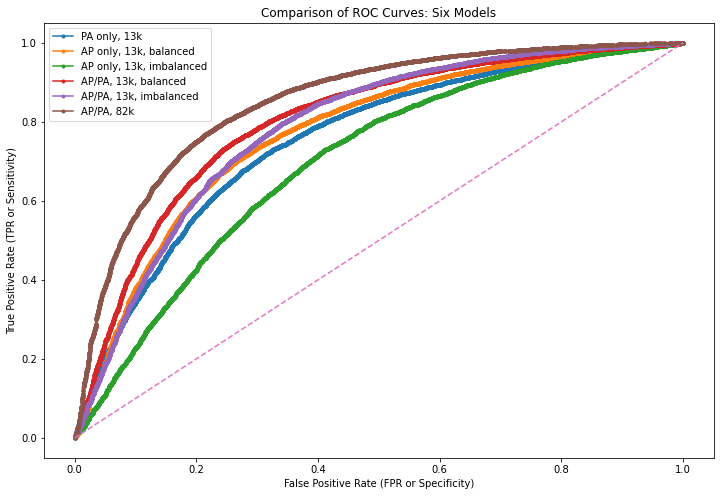

In [ ]:
plt.rcParams["figure.figsize"] = (12, 8)

y_cols = [c for c in test_with_preds.columns if c.startswith('pred')]

for y in y_cols:
  fpr, tpr, thresholds = roc_curve(test_with_preds.ground_truth, 
                                  test_with_preds[y])
  plt.plot(fpr, tpr, marker='.')
  l = len(thresholds)

plt.plot(np.arange(0, 1, 1 / l), np.arange(0, 1, 1 / l), linestyle = "--", label='random guessing')
plt.legend(
  [
    "PA only, 13k",
    "AP only, 13k, balanced",
    "AP only, 13k, imbalanced",
    "AP/PA, 13k, balanced",
    "AP/PA, 13k, imbalanced",
    f"AP/PA, {round(train.shape[0] / 1000)}k"
  ]
)
plt.title("Comparison of ROC Curves: Six Models")
plt.xlabel("False Positive Rate (FPR or Specificity)")
plt.ylabel("True Positive Rate (TPR or Sensitivity)")

plt.show()

Unsurprisingly, **the most performant model was the one that included all available images**; though some were of lesser quality than others, they were all representative of the training set and demonstrate the importance of having a large amount of data that is representative and unbiased with regard to your actual evaluation set.

We can see that this representativeness is very important, in that the other representative dataset, with 13,000 images of both AP and PA, with class balancing to make sure the model had enough of a look at PA images in such a small set, performed second best; but even with class imbalance, the dramatically larger amount of data available to the full training set made it perform much better.

#### Selecting the right threshold
For the purpose of this project, let's assume images between some threshold below mine and another number undergo human review, so I don't have to feel guilty about missing any symptoms with my model; this is just a first pass using automation to take out most likely cases while keeping false positives relatively low. I would like to maximize my true positive capture without bringing in too many false positives. 

Looking at the curve for my best model, it appears the inflection point is around 0.75-0.80; given that I want to balance those two factors, I will lean to the lower side of the two at 0.75 to establish my cutoff. Thus, I will not consider an image "positive" unless the neural net predicted positive to about 75% certainty.  All my models follow a roughly similar curve, so we will use this threshold for labeling with each.

We'll label them 'yes'/'no' using this logic, below:

#### Confusion matrices, Architecture 1

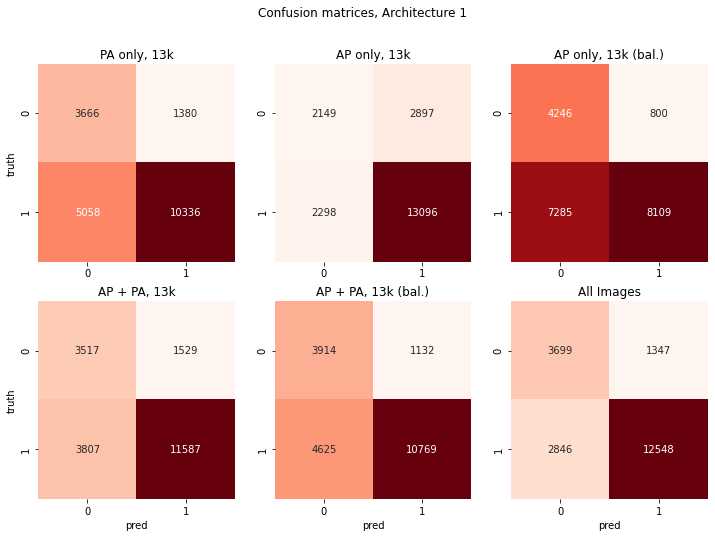

In [ ]:
plt.rcParams["figure.figsize"] = (12, 8)


truth = test_with_preds.ground_truth

# ['lbl_pa13k', ...]          
label_names = [y.replace('pred', 'lbl') for y in y_cols]

# combine input cols and output cols in list of tuples
pairs = list(zip(y_cols, label_names))

# for each pair of cols assign a label based on their being above or
# below a threshold
def threshold_classify(preds, thr):
  return [1.0 if p >= thr else 0.0 for p in preds]

for p in pairs:
  pred, lbl = p
  test_with_preds[lbl] = threshold_classify(test_with_preds[pred], 0.75)


# calculate AUC and F1 scores --------------------------------------------------
aucs = [roc_auc_score(truth, test_with_preds[y]) for y in y_cols]
f1s = [f1_score(truth, test_with_preds[l]) for l in label_names]


# create confusion matrices ----------------------------------------------------
cm_pa13k = confusion_matrix(truth, test_with_preds.lbl_pa13k)
cm_ap13k = confusion_matrix(truth, test_with_preds.lbl_ap13k)
cm_ap13k_bal = confusion_matrix(truth, test_with_preds.lbl_ap13k_bal)
cm_appa13k = confusion_matrix(truth, test_with_preds.lbl_appa13k)
cm_appa13k_bal = confusion_matrix(truth, test_with_preds.lbl_appa13k_bal)
cm_all = confusion_matrix(truth, test_with_preds.lbl_all)


# create confusion matrix heatmaps ---------------------------------------------
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
fig.suptitle('Confusion matrices, Architecture 1')

sns.heatmap(ax=axes[0,0], data=cm_pa13k, 
            annot=True, fmt="2d", cmap="Reds", cbar=False).set_title('PA only, 13k')

sns.heatmap(ax=axes[0,1], data=cm_ap13k, 
            annot=True, fmt="2d", cmap="Reds", cbar=False).set_title('AP only, 13k')

sns.heatmap(ax=axes[0,2], data=cm_ap13k_bal, 
            annot=True, fmt="2d", cmap="Reds", 
            cbar=False).set_title('AP only, 13k (bal.)')

sns.heatmap(ax=axes[1,0], data=cm_appa13k, annot=True, 
            fmt="2d", cmap="Reds", cbar=False).set_title('AP + PA, 13k')

sns.heatmap(ax=axes[1,1], data=cm_appa13k_bal, 
            annot=True, fmt="2d", cmap="Reds", 
            cbar=False).set_title('AP + PA, 13k (bal.)')

sns.heatmap(ax=axes[1,2], data=cm_all, annot=True, 
            fmt="2d", cmap="Reds", cbar=False).set_title('All Images')

# axis labels
axes[0,0].set(ylabel='truth')
axes[1,0].set(xlabel='pred', ylabel='truth')
axes[1,1].set(xlabel='pred')
axes[1,2].set(xlabel='pred')


fig.show()

The confusion matrix above is in the following order:  
  

$
\begin{bmatrix} 
TN & FP \\
FN & TP
\end{bmatrix}
$

Our "All Images" matrix has a good concentration of True Postives, whereas our AP-only balanced model had a heavy spread between TP and FN, meaning it missed a fair number of its actual positive cases (poor sensitivity).

#### Overall Architecture 1 Metrics
Below are the overall AUC scores for each model, along with the F1 score, a balanced metric of performance, using our threshold set at 0.75 to determine class membership.

The best performing model by both metrics was the **all images** model. With slightly differing results depending on the metrics, our worst performers were all three which only used one or the other set of x-ray positioning (all AP or all PA); to create a good model the neural net needed to see both types to be able to predict them in test, understandably.

In [ ]:
model_names = [y.replace('pred', 'model') for y in y_cols]
df_metrics = pd.DataFrame({'model': model_names,
                           'AUC': aucs,
                           'F1': f1s})

df_metrics

,model,AUC,F1
0,model_pa13k,0.754222,0.762523
1,model_ap13k_bal,0.771228,0.667325
2,model_ap13k,0.698893,0.834486
3,model_appa13k_bal,0.801384,0.789082
4,model_appa13k,0.785272,0.812838
5,model_all,0.849985,0.856840


#### Example images by classification

Below is a "Sample Confusion Matrix" of an example TN, FN, FP, and TP image as it was labeled by the model *model_all*.

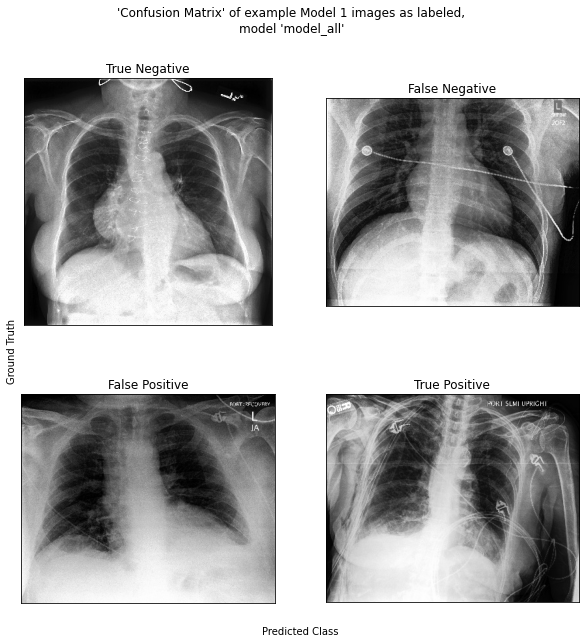

In [ ]:
# plt.rcParams.update({'font.size': 14})

tn = test_with_preds.query('ground_truth == 0.0 and lbl_all == 0.0')['project_path'].values[0]
fp = test_with_preds.query("ground_truth == 0.0 and lbl_all == 1.0")['project_path'].values[0]
fn = test_with_preds.query("ground_truth == 1.0 and lbl_all == 0.0")['project_path'].values[0]
tp = test_with_preds.query("ground_truth == 1.0 and lbl_all == 1.0")['project_path'].values[0]

cm_imgs = [tn, fp, fn, tp]
cm_imgs = [os.path.join(SAMPLE_DIR, i) for i in cm_imgs]


fig, big_ax = plt.subplots(figsize=(10,10))
big_ax.set_xticks([])
big_ax.set_yticks([])
big_ax.spines['left'].set_visible(False)
big_ax.spines['bottom'].set_visible(False)
big_ax.spines['right'].set_visible(False)
big_ax.spines['top'].set_visible(False)
big_ax.set_ylabel("Ground Truth")
big_ax.set_xlabel("Predicted Class")
fig.suptitle("'Confusion Matrix' of example Model 1 images as labeled,\nmodel 'model_all'")
titles = ['True Negative', 'False Negative', 'False Positive', 'True Positive']
for i, num in zip(cm_imgs, range(0,4)):
  img = cv.imread(i)
  ax = fig.add_subplot(2,2,num+1)
  ax.imshow(img)
  ax.set_title(titles[num])
  ax.set_xticks([])
  ax.set_yticks([])



## II. Improved model architecture
This model is an attempt to fix problems with the default model; though 
reasonable findings were made with the default model, upon review with my 
facilitator, we discovered that validation metrics (accuracy and loss) were not 
converging.  

Though to some degree it was still proving capable of reasonable 
performance 'out of the box' vs the test set, it was overperforming on the 
training set and failing to improve upon itself via the learning process. 
Using the below, 


In [ ]:
m_fc128 = Sequential()
# Step 1 - Convolution
m_fc128.add(Conv2D(32, (9, 9), input_shape = (resize, resize, 1), activation = 'relu', padding = 'same'))
# Step 2 - Pooling
m_fc128.add(MaxPooling2D(pool_size = (2, 2), strides = 2))
# Adding a second convolutional layer
m_fc128.add(Conv2D(64, (3, 3), activation = 'relu', padding = 'same'))
m_fc128.add(MaxPooling2D(pool_size = (2, 2), strides = 2))
# Step 3 - Flattening
m_fc128.add(Flatten())
# Step 4 - Full connection
m_fc128.add(Dense(units = 128, activation = 'relu'))
# Dropout to reduce overfit
m_fc128.add(Dropout(0.4)) 
m_fc128.add(Dense(units = 1, activation = 'sigmoid'))

m_fc128.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 64, 64, 32)        2624      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 16384)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               2097280   
_________________________________________________________________
dropout (Dropout)            (None, 128)              

### Architecture 2: Training
An additional change in this approach to reduce errors with loss is introduced during training: **reduction of the learning rate employed by Adam from the Keras default of 0.001 to 0.00025**. The wobbling back and forth between high and low peaks and overall trend upwards during train epochs in Model 1's training lead me to believe that part of the problem could have been too fast a learning rate, causing the model to oscillate around a minimum rather than descend to it. 

Note that due to limitations in colab, many of these models had to be trained over multiple sessions, meaning original console output during training has not been retained. 

The actual history, which is printed with some formatting, however, was saved to CSV for each training, and those results are below. Static evidence of training of some models has been saved and is included as static text along with training.

#### Sample 1. PA only, roughly balanced

In [ ]:
# 1. train model on 13,000 PA-only images, roughly balanced
model_pa13k_fc128, history_pa13k_fc128 = (
    load_or_train_model(
        train_pa, 
        resize=resize, 
        model=m_fc128, 
        model_name='pa13k_fc128',
        epochs=10,
        learnrate=0.00025
    )
)

history_pa13k_fc128

,loss,accuracy,auc,val_loss,val_accuracy,val_auc
0,1.092878,0.667115,0.710326,0.512281,0.757692,0.832732
1,0.554826,0.709231,0.793229,0.491442,0.767692,0.851617
2,0.513110,0.758173,0.828835,0.486999,0.771538,0.860614
3,0.496141,0.766058,0.841130,0.462352,0.783077,0.869450
4,0.470885,0.781250,0.858142,0.448573,0.800000,0.876269
5,0.448642,0.797596,0.873717,0.448372,0.806154,0.883554
6,0.423713,0.810769,0.888057,0.423026,0.814231,0.888167
7,0.408511,0.817692,0.896025,0.429534,0.805769,0.890849
8,0.392635,0.821058,0.903340,0.418979,0.807692,0.889253
9,0.372497,0.834808,0.913708,0.417735,0.820769,0.891004


#### Sample 2. AP only, imbalanced

In [ ]:
# 2. train model on 13,000 AP-only images, imbalanced
model_ap13k_fc128, history_ap13k_fc128 = (
    load_or_train_model(
        train_ap, 
        resize=resize, 
        model=m_fc128, 
        model_name='ap13k_fc128',
        epochs=10,
        learnrate=0.00025
    )
)

history_ap13k_fc128

,loss,accuracy,auc,val_loss,val_accuracy,val_auc
0,0.417483,0.824615,0.772716,0.389639,0.850000,0.808401
1,0.384598,0.845096,0.803649,0.346650,0.856154,0.839235
2,0.350224,0.858173,0.844588,0.350548,0.860385,0.837696
3,0.335701,0.867404,0.857739,0.340772,0.867308,0.849501
4,0.319553,0.870288,0.873780,0.340310,0.865769,0.850558
5,0.304489,0.877212,0.885410,0.333291,0.871923,0.859295
6,0.282460,0.885577,0.905330,0.356780,0.862308,0.839097
7,0.260343,0.890000,0.922080,0.354111,0.857308,0.847067
8,0.240254,0.898269,0.933622,0.372172,0.861923,0.843852
9,0.219089,0.907212,0.945254,0.380130,0.866154,0.836366


#### Sample 3. AP only, balanced

In [ ]:
# 3. train model on 13,000 AP-only images, balanced
model_ap13k_fc128_bal, history_ap13k_fc128_bal = (
    load_or_train_model(
        train_ap_bal, 
        resize=resize, 
        model=m_fc128, 
        model_name='ap13k_fc128_bal',
        epochs=10,
        learnrate=0.00025
    )
)

history_ap13k_fc128_bal

,loss,accuracy,auc,val_loss,val_accuracy,val_auc
0,0.488529,0.777596,0.855727,0.424723,0.813846,0.887403
1,0.452219,0.794327,0.874784,0.459503,0.795769,0.875146
2,0.416435,0.816058,0.894315,0.418383,0.818462,0.895345
3,0.383441,0.831346,0.910244,0.433638,0.810000,0.884445
4,0.353555,0.850865,0.924791,0.447759,0.813846,0.888768
5,0.308982,0.866538,0.942618,0.485274,0.805769,0.887802
6,0.272933,0.885673,0.955615,0.497240,0.807308,0.877696
7,0.238011,0.897404,0.966246,0.512445,0.812692,0.882108
8,0.202151,0.913654,0.975884,0.566287,0.802692,0.873163
9,0.175957,0.926538,0.981819,0.595459,0.806154,0.878772


#### Sample 4. AP/PA, imbalanced

In [ ]:
# 4. train model on 13,000 AP/PA images, imbalanced
model_appa13k_fc128, history_appa13k_fc128 = (
    load_or_train_model(
        train_appa, 
        resize=resize, 
        model=m_fc128, 
        model_name='appa13k_fc128',
        epochs=10,
        learnrate=0.00025
    )
)

history_appa13k_fc128

,loss,accuracy,auc,val_loss,val_accuracy,val_auc
0,0.379236,0.851827,0.881731,0.334883,0.870385,0.913475
1,0.323485,0.867212,0.909244,0.337579,0.861154,0.917387
2,0.283111,0.883750,0.930241,0.313180,0.869615,0.914424
3,0.248643,0.899135,0.945867,0.325540,0.873462,0.918433
4,0.211908,0.912404,0.960432,0.323553,0.871538,0.915886
5,0.181445,0.925865,0.972225,0.356584,0.870385,0.910072
6,0.162210,0.931827,0.977401,0.347928,0.866538,0.905309
7,0.132971,0.942212,0.984786,0.371271,0.865385,0.907477
8,0.114956,0.950481,0.989384,0.422843,0.865000,0.901180
9,0.106084,0.954615,0.990939,0.483552,0.866923,0.890952


#### Sample 5. AP/PA, balanced

In [ ]:
# train model on 13,000 AP/PA images, balanced
model_appa13k_fc128_bal, history_appa13k_fc128_bal = (
    load_or_train_model(
        train_appa_bal, 
        resize=resize, 
        model=m_fc128, 
        model_name='appa13k_fc128_bal',
        epochs=10,
        learnrate=0.00025
    )
)

history_appa13k_fc128_bal

,loss,accuracy,auc,val_loss,val_accuracy,val_auc
0,1.746201,0.651442,0.707298,0.492917,0.785000,0.859349
1,0.551212,0.709808,0.789851,0.489591,0.766923,0.863967
2,0.510369,0.746154,0.827212,0.447205,0.801154,0.876361
3,0.488063,0.762404,0.846457,0.441213,0.805000,0.881047
4,0.459475,0.781442,0.863644,0.438784,0.806154,0.882166
5,0.442511,0.782019,0.875559,0.432279,0.813462,0.883854
6,0.426776,0.797885,0.885596,0.443517,0.809615,0.887815
7,0.416140,0.798654,0.892288,0.426955,0.810385,0.890256
8,0.393751,0.808942,0.903282,0.431487,0.815769,0.890808
9,0.381065,0.814231,0.909900,0.444653,0.808462,0.890534




```
Epoch 1/10
325/325 [==============================] - 30s 91ms/step - loss: 1.7462 - accuracy: 0.6514 - auc_7: 0.7073 - val_loss: 0.4929 - val_accuracy: 0.7850 - val_auc_7: 0.8593
Epoch 2/10
325/325 [==============================] - 29s 88ms/step - loss: 0.5512 - accuracy: 0.7098 - auc_7: 0.7899 - val_loss: 0.4896 - val_accuracy: 0.7669 - val_auc_7: 0.8640
Epoch 3/10
325/325 [==============================] - 29s 90ms/step - loss: 0.5104 - accuracy: 0.7462 - auc_7: 0.8272 - val_loss: 0.4472 - val_accuracy: 0.8012 - val_auc_7: 0.8764
Epoch 4/10
325/325 [==============================] - 30s 91ms/step - loss: 0.4881 - accuracy: 0.7624 - auc_7: 0.8465 - val_loss: 0.4412 - val_accuracy: 0.8050 - val_auc_7: 0.8810
Epoch 5/10
325/325 [==============================] - 29s 91ms/step - loss: 0.4595 - accuracy: 0.7814 - auc_7: 0.8636 - val_loss: 0.4388 - val_accuracy: 0.8062 - val_auc_7: 0.8822
Epoch 6/10
325/325 [==============================] - 30s 91ms/step - loss: 0.4425 - accuracy: 0.7820 - auc_7: 0.8756 - val_loss: 0.4323 - val_accuracy: 0.8135 - val_auc_7: 0.8839
Epoch 7/10
325/325 [==============================] - 30s 92ms/step - loss: 0.4268 - accuracy: 0.7979 - auc_7: 0.8856 - val_loss: 0.4435 - val_accuracy: 0.8096 - val_auc_7: 0.8878
Epoch 8/10
325/325 [==============================] - 29s 90ms/step - loss: 0.4161 - accuracy: 0.7987 - auc_7: 0.8923 - val_loss: 0.4270 - val_accuracy: 0.8104 - val_auc_7: 0.8903
Epoch 9/10
325/325 [==============================] - 29s 89ms/step - loss: 0.3938 - accuracy: 0.8089 - auc_7: 0.9033 - val_loss: 0.4315 - val_accuracy: 0.8158 - val_auc_7: 0.8908
Epoch 10/10
325/325 [==============================] - 32s 98ms/step - loss: 0.3811 - accuracy: 0.8142 - auc_7: 0.9099 - val_loss: 0.4447 - val_accuracy: 0.8085 - val_auc_7: 0.8905
Saved history to /content/drive/MyDrive/Colab Projects/METCS767_LungStudy/models/appa13k_fc128_bal_history.csv.
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Projects/METCS767_LungStudy/models/appa13k_fc128_bal/assets
```



#### Sample 6. All available train images

In [ ]:
# train model on 13,000 AP images, balanced
model_all_fc128, history_all_fc128 = (
    load_or_train_model(
        train, 
        resize=resize, 
        model=m_fc128, 
        model_name='all_fc128',
        epochs=10,
        learnrate=0.00025
    )
)

history_all_fc128

,loss,accuracy,auc,val_loss,val_accuracy,val_auc
0,0.379414,0.842112,0.869013,0.443004,0.803077,0.908395
1,0.347595,0.857477,0.890320,0.558517,0.756923,0.915526
2,0.331556,0.864663,0.900553,0.455079,0.786538,0.923279
3,0.316809,0.870213,0.909929,0.422771,0.814231,0.933926
4,0.305424,0.875273,0.916961,0.385622,0.833462,0.939684
5,0.294161,0.880900,0.923245,0.371455,0.837692,0.938335
6,0.279215,0.885547,0.931409,0.361058,0.830769,0.951028
7,0.265445,0.892611,0.937918,0.332345,0.849231,0.953403
8,0.251090,0.898252,0.944968,0.301377,0.872308,0.962781
9,0.236394,0.903007,0.951472,0.288515,0.879231,0.966731




```
Epoch 1/10
2044/2044 [==============================] - 33622s 16s/step - loss: 0.3794 - accuracy: 0.8421 - auc_9: 0.8690 - val_loss: 0.4430 - val_accuracy: 0.8031 - val_auc_9: 0.9084
Epoch 2/10
2044/2044 [==============================] - 176s 86ms/step - loss: 0.3476 - accuracy: 0.8575 - auc_9: 0.8903 - val_loss: 0.5585 - val_accuracy: 0.7569 - val_auc_9: 0.9155
Epoch 3/10
2044/2044 [==============================] - 173s 85ms/step - loss: 0.3316 - accuracy: 0.8647 - auc_9: 0.9006 - val_loss: 0.4551 - val_accuracy: 0.7865 - val_auc_9: 0.9233
Epoch 4/10
2044/2044 [==============================] - 176s 86ms/step - loss: 0.3168 - accuracy: 0.8702 - auc_9: 0.9099 - val_loss: 0.4228 - val_accuracy: 0.8142 - val_auc_9: 0.9339
Epoch 5/10
2044/2044 [==============================] - 175s 86ms/step - loss: 0.3054 - accuracy: 0.8753 - auc_9: 0.9170 - val_loss: 0.3856 - val_accuracy: 0.8335 - val_auc_9: 0.9397
Epoch 6/10
2044/2044 [==============================] - 173s 85ms/step - loss: 0.2942 - accuracy: 0.8809 - auc_9: 0.9232 - val_loss: 0.3715 - val_accuracy: 0.8377 - val_auc_9: 0.9383
Epoch 7/10
2044/2044 [==============================] - 174s 85ms/step - loss: 0.2792 - accuracy: 0.8855 - auc_9: 0.9314 - val_loss: 0.3611 - val_accuracy: 0.8308 - val_auc_9: 0.9510
Epoch 8/10
2044/2044 [==============================] - 173s 84ms/step - loss: 0.2654 - accuracy: 0.8926 - auc_9: 0.9379 - val_loss: 0.3323 - val_accuracy: 0.8492 - val_auc_9: 0.9534
Epoch 9/10
2044/2044 [==============================] - 175s 86ms/step - loss: 0.2511 - accuracy: 0.8983 - auc_9: 0.9450 - val_loss: 0.3014 - val_accuracy: 0.8723 - val_auc_9: 0.9628
Epoch 10/10
2044/2044 [==============================] - 174s 85ms/step - loss: 0.2364 - accuracy: 0.9030 - auc_9: 0.9515 - val_loss: 0.2885 - val_accuracy: 0.8792 - val_auc_9: 0.9667
Saved history to /content/drive/MyDrive/Colab Projects/METCS767_LungStudy/models/all_fc128_history.csv.
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Projects/METCS767_LungStudy/models/all_fc128/assets
Total time to train: 9:47:11.856637
```



### Model 2 validation metrics

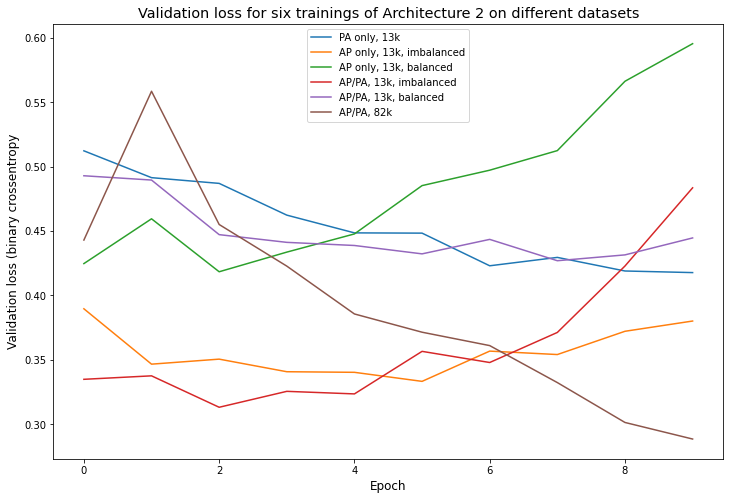

In [ ]:
val_losses = [
  history_pa13k_fc128.val_loss, 
  history_ap13k_fc128.val_loss,
  history_ap13k_fc128_bal.val_loss,
  history_appa13k_fc128.val_loss,
  history_appa13k_fc128_bal.val_loss,
  history_all_fc128.val_loss
]

for loss in val_losses:
  plt.plot(range(10), loss)

leg = [
  "PA only, 13k",
  "AP only, 13k, imbalanced",
  "AP only, 13k, balanced",
  "AP/PA, 13k, imbalanced",
  "AP/PA, 13k, balanced",
  f"AP/PA, {round(train.shape[0] / 1000)}k"
]
plt.legend(leg)
plt.xlabel("Epoch", fontsize='large')
plt.ylabel("Validation loss (binary crossentropy", fontsize='large')
plt.title("Validation loss for six trainings of Architecture 2 on different datasets",
          fontsize='x-large')
plt.show()

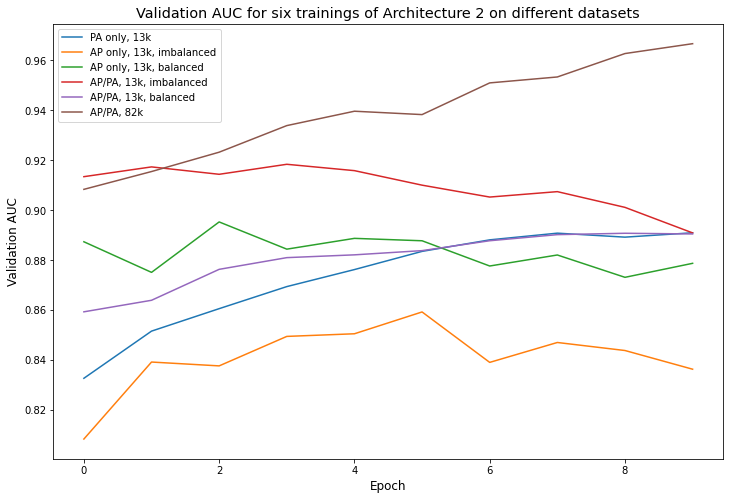

In [ ]:
val_aucs = [
  history_pa13k_fc128.val_auc, 
  history_ap13k_fc128.val_auc,
  history_ap13k_fc128_bal.val_auc,
  history_appa13k_fc128.val_auc,
  history_appa13k_fc128_bal.val_auc,
  history_all_fc128.val_auc
]

for auc in val_aucs:
  plt.plot(range(10), auc)

leg = [
  "PA only, 13k",
  "AP only, 13k, imbalanced",
  "AP only, 13k, balanced",
  "AP/PA, 13k, imbalanced",
  "AP/PA, 13k, balanced",
  f"AP/PA, {round(train.shape[0] / 1000)}k"
]
plt.legend(leg)
plt.xlabel("Epoch", fontsize='large')
plt.ylabel("Validation AUC", fontsize='large')
plt.title("Validation AUC for six trainings of Architecture 2 on different datasets",
          fontsize='x-large')
plt.show()

### Model 2: Predict new values and evaluate test metrics

In [ ]:
preds_path = os.path.join(HERE, 'test_with_predictions_m2.csv')

if os.path.exists(preds_path):
  test_with_preds_m2 = pd.read_csv(preds_path)

  test_with_preds_m2
  
else:
  start = datetime.datetime.now()

  test_with_preds_m2 = test.assign(**{
      'pred_pa13k_m2': model_pa13k_fc128.predict(test_ds, verbose=1)
    , 'pred_ap13k_m2': model_ap13k_fc128.predict(test_ds, verbose=1)
    , 'pred_ap13k_m2_bal': model_ap13k_fc128_bal.predict(test_ds, verbose=1)
    , 'pred_appa13k_m2': model_appa13k_fc128.predict(test_ds, verbose=1)
    , 'pred_appa13k_m2_bal': model_appa13k_fc128_bal.predict(test_ds, verbose=1)
    , 'pred_all_m2': model_all_fc128_bal.predict(test_ds, verbose=1)
  })
  test_with_preds_m2.to_csv(preds_path, index=False)

  end = datetime.datetime.now()
  dur = (end - start).total_seconds()
  print(f"Took {dur} seconds to predict.")

test_with_preds_m2 = test_with_preds_m2[[
    'index'
  , 'old_index'
  , 'project_path'
  , 'ap_pa'
  , 'pleural_effusion'
  , 'pred_pa13k_m2'
  , 'pred_ap13k_m2'
  , 'pred_ap13k_m2_bal'
  , 'pred_appa13k_m2'
  , 'pred_appa13k_m2_bal'
  , 'pred_all_m2'
]]

# relabel our yes/nos as numeric so sklearn can compute 
# TPR/FPR numerically
test_with_preds_m2['ground_truth'] = (
    test_with_preds_m2
    .pleural_effusion
    .apply(lambda x: 1.0 if x == 'yes' else 0.0)
)

test_with_preds_m2

,index,old_index,project_path,ap_pa,pleural_effusion,pred_pa13k_m2,pred_ap13k_m2,pred_ap13k_m2_bal,pred_appa13k_m2,pred_appa13k_m2_bal,pred_all_m2,ground_truth
0,77437,171880,subfolder_154/img_077437.jpg,AP,yes,0.945773,0.915993,0.441289,0.998226,0.203934,0.665813,1.0
1,66530,151917,subfolder_133/img_066530.jpg,AP,yes,0.373582,0.849131,0.041240,0.532918,0.232990,0.252857,1.0
2,51648,120306,subfolder_103/img_051648.jpg,AP,yes,0.827312,0.847631,0.717163,1.000000,0.944286,0.998063,1.0
3,36229,84910,subfolder_072/img_036229.jpg,AP,yes,0.614424,0.714734,0.084329,0.966811,0.450043,0.995978,1.0
4,100563,219717,subfolder_201/img_100563.jpg,AP,yes,0.556269,0.713625,0.634701,0.858493,0.872322,0.720821,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
20435,95592,208330,subfolder_191/img_095592.jpg,AP,yes,0.433972,0.202573,0.018969,0.998972,0.165198,0.372631,1.0
20436,29634,69250,subfolder_059/img_029634.jpg,AP,yes,0.984499,0.988056,0.993216,0.999999,0.926024,0.995696,1.0
20437,97170,211906,subfolder_194/img_097170.jpg,AP,no,0.260901,0.318764,0.000102,0.993211,0.086011,0.184586,0.0
20438,63343,146280,subfolder_126/img_063343.jpg,AP,yes,0.810109,0.754019,0.182555,0.904957,0.327492,0.903134,1.0


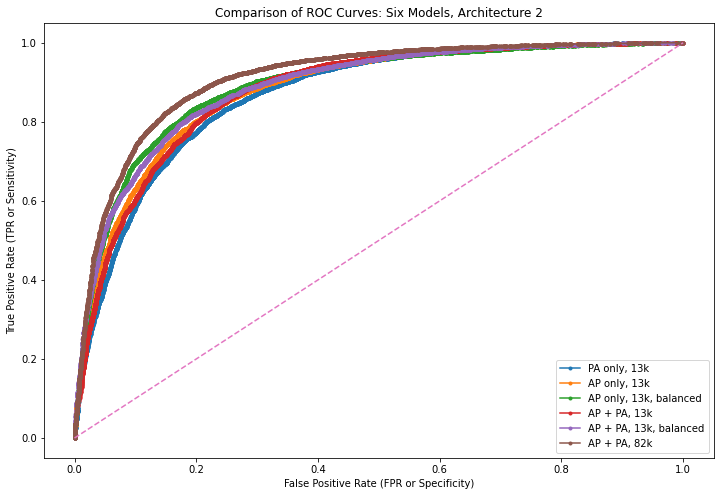

In [ ]:
plt.rcParams["figure.figsize"] = (12, 8)

y_cols = [c for c in test_with_preds_m2.columns if c.startswith('pred')]

for y in y_cols:
  fpr, tpr, thresholds = roc_curve(test_with_preds_m2.ground_truth, 
                                   test_with_preds_m2[y])
  plt.plot(fpr, tpr, marker='.')
  l = len(thresholds)

plt.plot(np.arange(0, 1, 1 / l), np.arange(0, 1, 1 / l), linestyle = "--", label='random guessing')
plt.legend([
    "PA only, 13k"
  , "AP only, 13k"
  , "AP only, 13k, balanced"
  , "AP + PA, 13k"
  , "AP + PA, 13k, balanced"
  , f"AP + PA, {round(train.shape[0] / 1000)}k"

])
plt.title("Comparison of ROC Curves: Six Models, Architecture 2")
plt.xlabel("False Positive Rate (FPR or Specificity)")
plt.ylabel("True Positive Rate (TPR or Sensitivity)")
plt.show()

As we can see the second architecture and training hyperparameter increased the model's AUC performance metrics, though not exactly consistently; we'll compare exact model performances to each other in a moment. As a whole, with the second approach, the full training set being fed to the model resulted in the best curve, but for each less performant sample, the model was able to still more effectively predict labels than with the prior architecture and greater learning rate. 

While we already have our AUC scores, we need to pick a value for our threshold again to create confusion matrices, predict class labels, and arrive at our F1 balanced score.

For consistency's sake, and because it appears to be a similarly good breaking point, we'll go with 0.75 for our threshold.

#### Selecting threshold and labeling classes

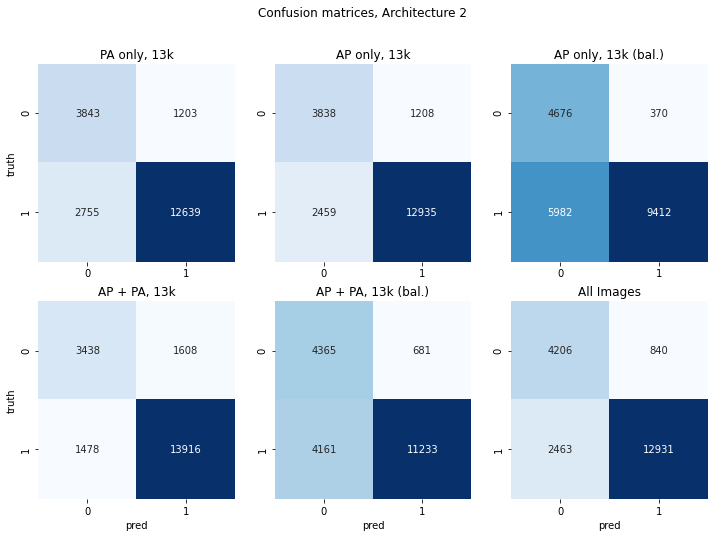

In [ ]:
# plt.rcParams["figure.figsize"] = (12, 8)

truth = test_with_preds_m2.ground_truth

# ['lbl_pa13k', ...]          
label_names = [y.replace('pred', 'lbl') for y in y_cols]

# combine input cols and output cols in list of tuples
pairs = list(zip(y_cols, label_names))

# for each pair of cols assign a label based on their being above or
# below a threshold
def threshold_classify(preds, thr):
  return [1.0 if p >= thr else 0.0 for p in preds]

for p in pairs:
  pred, lbl = p
  test_with_preds_m2[lbl] = threshold_classify(test_with_preds_m2[pred], 0.75)


# calculate AUC and F1 scores --------------------------------------------------
aucs = [roc_auc_score(truth, test_with_preds_m2[y]) for y in y_cols]
f1s = [f1_score(truth, test_with_preds_m2[l]) for l in label_names]


# create confusion matrices ----------------------------------------------------
cm_pa13k = confusion_matrix(truth, test_with_preds_m2.lbl_pa13k_m2)
cm_ap13k = confusion_matrix(truth, test_with_preds_m2.lbl_ap13k_m2)
cm_ap13k_bal = confusion_matrix(truth, test_with_preds_m2.lbl_ap13k_m2_bal)
cm_appa13k = confusion_matrix(truth, test_with_preds_m2.lbl_appa13k_m2)
cm_appa13k_bal = confusion_matrix(truth, test_with_preds_m2.lbl_appa13k_m2_bal)
cm_all = confusion_matrix(truth, test_with_preds_m2.lbl_all_m2)


# create confusion matrix heatmaps ---------------------------------------------
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
fig.suptitle('Confusion matrices, Architecture 2')

sns.heatmap(ax=axes[0,0], data=cm_pa13k, 
            annot=True, fmt="2d", cmap="Blues", cbar=False).set_title('PA only, 13k')

sns.heatmap(ax=axes[0,1], data=cm_ap13k, 
            annot=True, fmt="2d", cmap="Blues", cbar=False).set_title('AP only, 13k')

sns.heatmap(ax=axes[0,2], data=cm_ap13k_bal, 
            annot=True, fmt="2d", cmap="Blues", 
            cbar=False).set_title('AP only, 13k (bal.)')

sns.heatmap(ax=axes[1,0], data=cm_appa13k, annot=True, 
            fmt="2d", cmap="Blues", cbar=False).set_title('AP + PA, 13k')

sns.heatmap(ax=axes[1,1], data=cm_appa13k_bal, 
            annot=True, fmt="2d", cmap="Blues", 
            cbar=False).set_title('AP + PA, 13k (bal.)')

sns.heatmap(ax=axes[1,2], data=cm_all, annot=True, 
            fmt="2d", cmap="Blues", cbar=False).set_title('All Images')

# axis labels
axes[0,0].set(ylabel='truth')
axes[1,0].set(xlabel='pred', ylabel='truth')
axes[1,1].set(xlabel='pred')
axes[1,2].set(xlabel='pred')


fig.show()

## Overall model comparisons
Finally, we will compare metrics model-for-model to see how they changed in performance from one architecture and hyperparameter value to the other.

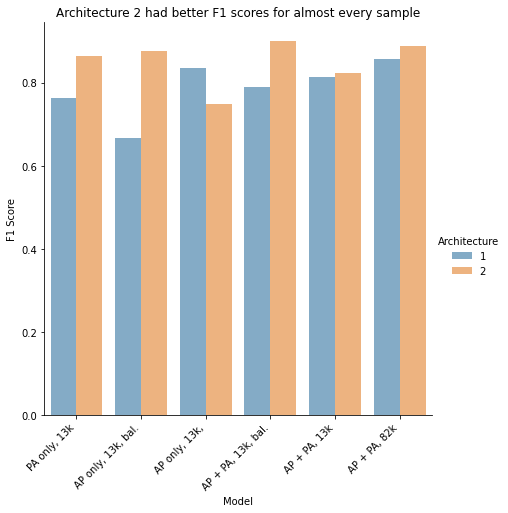

In [ ]:
# create a metrics set for first approach
df_metrics_1 = df_metrics.copy()
df_metrics_1['Architecture'] = 1
df_metrics_1

# rename from above variable that reused aucs and f1s
aucs_2 = aucs
f1s_2 = f1s

# and second
df_metrics_2 = pd.DataFrame({'model': model_names,
                           'AUC': aucs_2,
                           'F1': f1s_2,
                           'Architecture': 2})




# combine them
df_combined_metrics = pd.concat([df_metrics_1, df_metrics_2]).reset_index(drop=True)
df_combined_metrics


# F1 score ------
g = sns.catplot(
    data=df_combined_metrics, kind="bar",
    x="model", y="F1", hue="Architecture", alpha=.6, height=6,
    orient='v'
)
g.set_axis_labels(y_var="F1 Score", x_var="Model")
g.set_xticklabels(
    [
     'PA only, 13k',
     'AP only, 13k, bal.',
     'AP only, 13k,',
     'AP + PA, 13k, bal.',
     'AP + PA, 13k',
     f'AP + PA, {round(train.shape[0] / 1000)}k'
    ],
    rotation=45, 
    ha='right'
)
plt.title("Architecture 2 had better F1 scores for almost every sample")

plt.show()


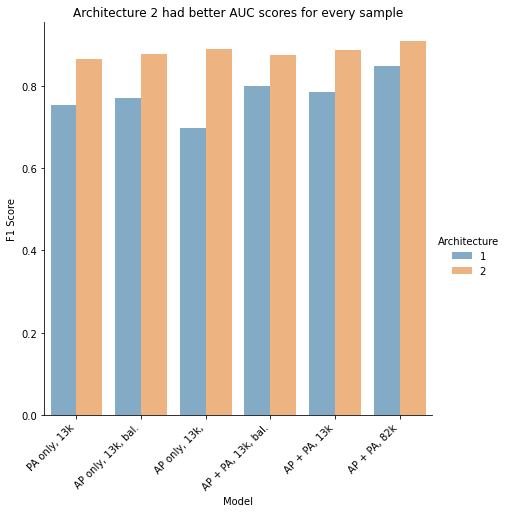

In [ ]:
# AUC score ------
g = sns.catplot(
    data=df_combined_metrics, kind="bar",
    x="model", y="AUC", hue="Architecture", alpha=.6, height=6,
    orient='v'
)
g.set_axis_labels(y_var="F1 Score", x_var="Model")
g.set_xticklabels(
    [
     'PA only, 13k',
     'AP only, 13k, bal.',
     'AP only, 13k,',
     'AP + PA, 13k, bal.',
     'AP + PA, 13k',
     f'AP + PA, {round(train.shape[0] / 1000)}k'
    ],
    rotation=45, 
    ha='right'
)
plt.title(
  """Architecture 2 had better AUC scores for every sample"""
)

plt.show()


In [ ]:
df_metrics_combined = pd.merge(
    df_metrics_1.drop('Architecture', 1).rename(columns={'AUC':'AUC Arch 1', 'F1':'F1 Arch 1'}),
    df_metrics_2.drop('Architecture', 1).rename(columns={'AUC':'AUC Arch 2', 'F1':'F1 Arch 2'}),
    left_on='model', right_on='model'
)


df_metrics_combined['model'] = [
  "PA only, 13k",
  "AP only, 13k, balanced",
  "AP only, 13k, imbalanced", 
  "AP + PA, 13k, balanced", 
  "AP + PA, 13k, imbalanced",
  f"AP + PA, {round(train.shape[0] / 1000)}k"
]

metrics_with_summary = df_metrics_combined.append(df_metrics_combined.mean().rename('Avg'))
metrics_with_summary.iloc[-1, 0] = '--'

metrics_with_summary

,model,AUC Arch 1,F1 Arch 1,AUC Arch 2,F1 Arch 2
0,"PA only, 13k",0.754222,0.762523,0.866837,0.864619
1,"AP only, 13k, balanced",0.771228,0.667325,0.879218,0.875851
2,"AP only, 13k, imbalanced",0.698893,0.834486,0.890028,0.747696
3,"AP + PA, 13k, balanced",0.801384,0.789082,0.876321,0.900188
4,"AP + PA, 13k, imbalanced",0.785272,0.812838,0.887581,0.822689
5,"AP + PA, 82k",0.849985,0.856840,0.910041,0.886748
Avg,--,0.776831,0.787182,0.885004,0.849632


## Model architecture 1 diagram

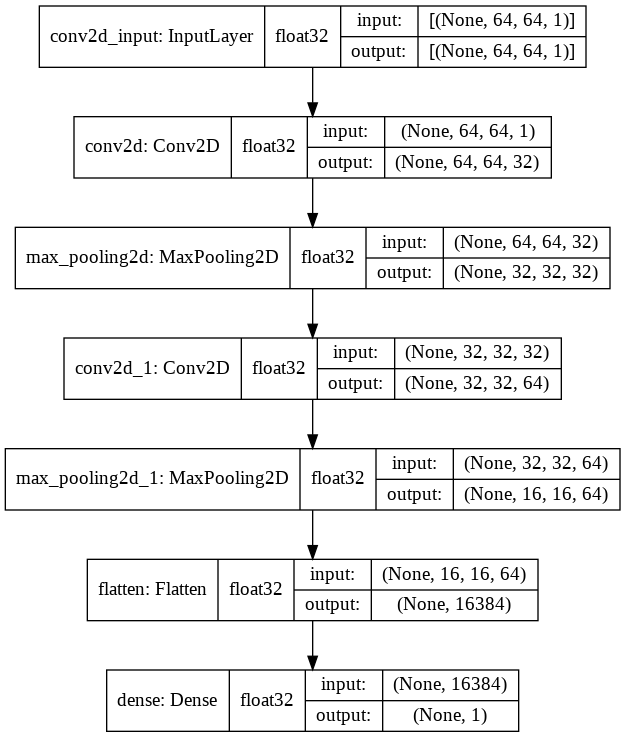

In [ ]:
tf.keras.utils.plot_model(default_model,  show_shapes=True, show_dtype=True)

## Model architecture 2 diagram

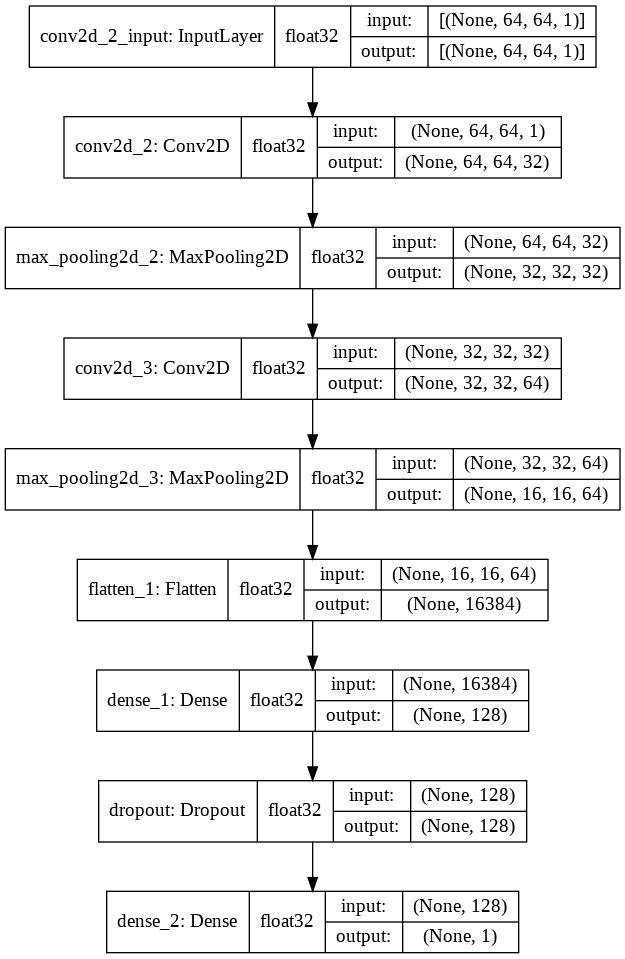

In [ ]:
tf.keras.utils.plot_model(m_fc128,  show_shapes=True, show_dtype=True)

## Final Risks:
  1. The new massive dataset is too large to train
    - Retired: the large model took about three hours to train. The GPU massively improves performance.
  2. Final performance (on test) is poor for all but the largest or most complete datasets: *This is less of a risk and more a hypothesis to test, but will retire when I have findings that reflect one or the other ways.*
    - Retired: It turns out my model worked well! I was able to achieve reasonably high F1 scores and AUC scores with my design.
  3. Long time to train between models and occasional service disconnections on colab (service is extended on my paid plan but still not guaranteed intermittently disconnected to prevent bitcoin mining) may lead to disruption during or very long model fitting with the model in RAM lost when kernel resets
    - Retired: I have implemented model and validation history save to disk, so that when kernel resets already trained models can be loaded from storage.
  4. AUC operates in an unexpected way by Keras high level API as does evaluate vs. Predict
    - Retired: I calculated AUC using a more familiar outside package (scikit-learn), rather than trusting Keras under the hood. 
  5. Poor training performance on model architecture - observing training epochs showed problems with either overfitting on train data when shown validation, or something with model architecture requires improvement
    - Retired: a second model architecture with small changes was developed: 
        - Now starts with 32 filters of conv layer, using 9x9 kernel, as before, 
        - But after / 2 max pool, passes to 64 filter 3x3 kernel conv layer before next / 2 max pool. 
        - Instead of merely flattening and passing to final sigmoid node, flattens, then densely connects to 128 nodes for further training on activations, then passes to final single sigmoid node
        - Finally, during each train, a dropout layer is added, creating a probabability of 40% that any given neuron is dropped, to reduce overfitting

        - During training, Adam optimizer uses a slower learning rate, from 0.001 to 0.00025

        Improved most models' F1 scores, all models' AUCs, reduced loss function oscillations for many samples during training

## Extra: Model Visualizations
Because often neural nets are treated like a black box, I have been particularly curious for any ways to better understand what is happening inside the 'hidden' layers. 

Below are attempts to visualize feature maps from the final conv layer of the *model_all* model, from the  This employs the [tf-keras-vis](https://github.com/keisen/tf-keras-vis/) package.

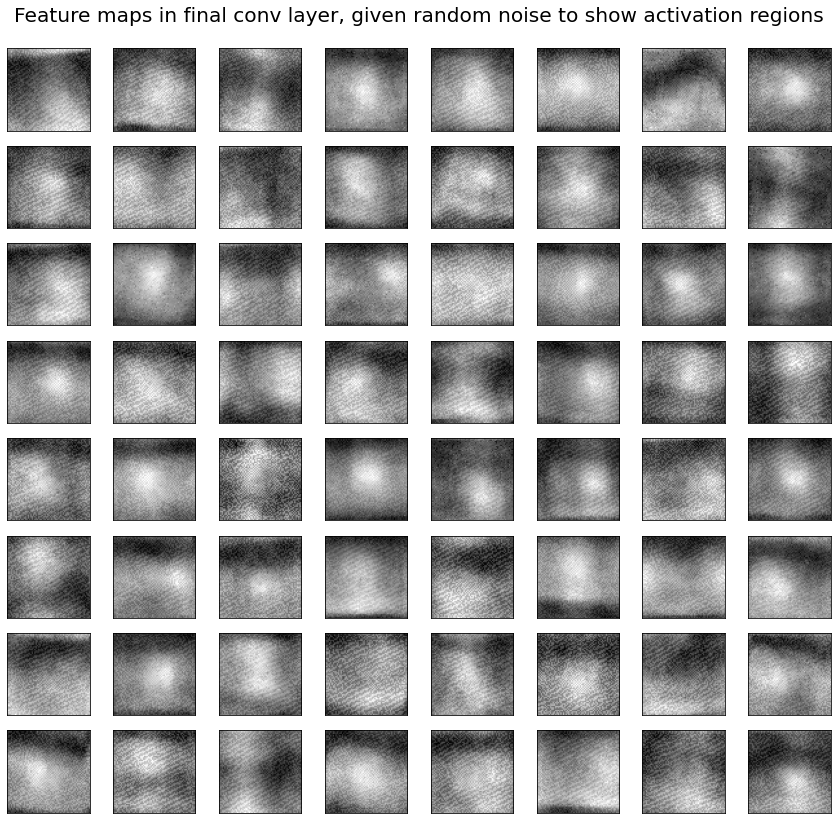

In [ ]:
# visualize feature maps from conv layer
filters = []
for i in range(64):
  layer_name = 'conv2d_3'

  def model_modifier(current_model):
      target_layer = current_model.get_layer(name=layer_name)
      new_model = tf.keras.Model(inputs=current_model.inputs,
                                outputs=target_layer.output)
      new_model.layers[-1].activation = tf.keras.activations.linear
      return new_model

  activation_maximization = ActivationMaximization(model_all, model_modifier)
  
  filter_number = i
  def loss(output):
      return output[..., filter_number]

  # Generate max activation
  activation = activation_maximization(loss)
  image = activation[0].astype(np.uint8)
  img = tf.squeeze(image)

  filters.append(img)

plt.figure(figsize=(12,12)) # specifying the overall grid size
plt.suptitle("Feature maps in final conv layer, given random noise to show activation regions", size="x-large")

# for index, row in images_to_plot.reset_index().iterrows():
for index, filter in zip(range(len(filters)), filters):
    # img = cv.imread(os.path.join(SAMPLE_DIR, row.project_path))
    plt.subplot(8,8,index+1)
    plt.tick_params(
        bottom=False, top=False, left=False, right=False,
        labelbottom=False, labeltop=False, labelleft=False, labelright=False
    )
    # plt.xticks([0, 1, 1])

    plt.imshow(filter, cmap='gray')
    # plt.close()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# APPENDIX: Useful Notes
1. https://stackoverflow.com/questions/57519937/how-to-use-model-predict-for-predicting-single-image-in-tf-keras
This has information for how to get test set results labeled to determine metrics
2. https://towardsdatascience.com/optimizers-for-training-neural-network-59450d71caf6 - optimizer approaches for training
3. Keras flow from dataframe: https://vijayabhaskar96.medium.com/tutorial-on-keras-flow-from-dataframe-1fd4493d237c
4. Flow from dataframe in Keras documentation: https://keras.io/api/preprocessing/image/
5. Plotting images in Matplotlib: https://stackoverflow.com/questions/35286540/display-an-image-with-python
6. What does validation partition do in Keras? https://stackoverflow.com/questions/46308374/what-is-validation-data-used-for-in-a-keras-sequential-model 
7. Introduction to CNNs: https://victorzhou.com/blog/keras-cnn-tutorial/
8. How to save a Keras model: https://www.tensorflow.org/guide/keras/save_and_serialize
9. Something to come back to: how to visualize the optimization process in a filter: https://github.com/raghakot/keras-vis
10. how to load images for prediction in Keras: https://stackoverflow.com/questions/43469281/how-to-predict-input-image-using-trained-model-in-keras
11. ROC curves in Python: https://medium.com/@kunanba/what-is-roc-auc-and-how-to-visualize-it-in-python-f35708206663 | https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
12. Multiple plotting with Seaborn: https://dev.to/thalesbruno/subplotting-with-matplotlib-and-seaborn-5ei8
13. Visualizing attention weights in Keras:
  - https://www.machinecurve.com/index.php/2019/11/25/visualizing-keras-cnn-attention-saliency-maps/


#### Learnings/findings while working through 

  - **Q**: How do more than one filters work? 
  - **A**: Each layer is its own collection of neurons, which represent the activations of neurons recognizing the area of presence of a pattern represented in that filter.
  - **Q**: Max pooling, How does it work?
  - **A**: After we pass each filter over the image, we have a **feature map**, which is then activated by the activation function in the layer. When it is passed to a **max pooling** layer, the pooling layer passes over (also convolves) across the feature map, selecting from each region into the new feature map the maximum value. This can have both a performance (speed) improving function, and also a functional one of only passing through the strongest signals from a specific region of the image as to the presence of a
  relevant feature.
  - **Q**: When I run AUC as a metric during training, I get an output shape error. What am I doing wrong?
  - **A**: This was caused by a prior implementation of the model that output two nodes, one for each label, with probability values activated by the softmax function. AUC requires a single output node predicting label, in this case by the sigmoid function. AUC works by determining the TPR vs FPR given different cutoff thresholds for the score put out by the prediction function, a decision made outside the model, such that the area under the curve above the guessing line running the diagonal represents the degree to which the model is able to predict labels with maximum effect of catching positives and minimum effect of bringing in false positives along the way.

# Appendix 2: AlexNet for binary classification